## Agentnet intro

In this tutorial we'll
* еrain on Atari MsPacman game with deterministic framerate using OpenAI gym
* train a simple lasagne neural network for n-step q-learning
* no experience replay, 10 synchronous agents, soft target networks

_Note that this agent is not state of the art on this particular game_, it's just simple and it works.


### About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


### New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
#setup theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=gpu0,floatX=float32

env: THEANO_FLAGS=device=gpu0,floatX=float32


In [2]:
#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1



# Experiment setup
* Here we basically just load the game and check that it works

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 10

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 45.0% of memory, cuDNN 5105)
[2017-02-22 03:16:51,268] Making new env: MsPacmanDeterministic-v0


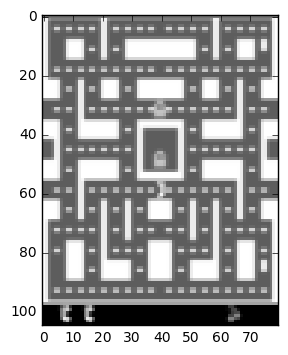

In [4]:
import gym
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
#game maker consider https://gym.openai.com/envs
def make_env():
    env = gym.make("MsPacmanDeterministic-v0")
    return PreprocessImage(env,height=105,width=80,
                           grayscale=True,
                           crop=lambda img:img[:-25])

#spawn game instance
env = make_env()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.step(0)[0]

plt.imshow(obs[0],interpolation='none',cmap='gray')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
import theano, lasagne
from lasagne.layers import *

In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
prev_wnd.output_shape,new_wnd.output_shape

((None, 4, 1, 105, 80), (None, 4, 1, 105, 80))

In [8]:
from lasagne.nonlinearities import elu,tanh,softmax

#network body
conv0 = Conv2DLayer(wnd_reshape,32,3,stride=2,nonlinearity=elu)
conv1 = Conv2DLayer(conv0,32,3,stride=2,nonlinearity=elu)
conv2 = Conv2DLayer(conv1,64,3,stride=2,nonlinearity=elu)
conv3 = Conv2DLayer(conv2,128,3,stride=2,nonlinearity=elu)
        
dense = DenseLayer(dropout(conv3,0.1),512,nonlinearity=tanh,name='dense')

In [9]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [10]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer,conv2)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [11]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [12]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, W, b, W, b, dense.W, dense.b, qval.W, qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [13]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, N_AGENTS) #may need to adjust


[2017-02-22 03:16:52,267] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,299] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,326] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,350] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,374] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,398] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,424] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,448] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,472] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:16:52,496] Making new env: MsPacmanDeterministic-v0


In [14]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(10)

print('actions:')
print(action_log[0])
print("rewards")
print(reward_log[0])

actions:
[5 2 2 2 8 2 2 2 2 5]
rewards
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
CPU times: user 228 ms, sys: 16 ms, total: 244 ms
Wall time: 241 ms


In [15]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [16]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



/anaconda3/envs/py27/lib/python2.7/site-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=1] optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [17]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
rewards = replay.rewards/10.

#loss for Qlearning = 
#(Q(s,a) - (r+ gamma*r' + gamma^2*r'' + ...  +gamma^10*Q(s_{t+10},a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=10)

#mean over all batches and time ticks
loss = elwise_mse_loss.mean()

In [18]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
train_step = theano.function([],loss,updates=updates)

# Demo run

In [19]:
action_layer.epsilon.set_value(0)

untrained_reward = np.mean(pool.evaluate(save_path="./records",
                                         record_video=True))

[2017-02-22 03:17:32,373] Making new env: MsPacmanDeterministic-v0
[2017-02-22 03:17:32,402] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 03:17:32,404] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-02-22 03:17:32,419] Starting new video recorder writing to /home/hedgedir/rl_projects/records/openaigym.video.0.34712.video000000.mp4
[2017-02-22 03:17:34,054] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/rl_projects/records')


Episode finished after 333 timesteps with reward=190.0


In [20]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward_per_tick,reward =0,0,0

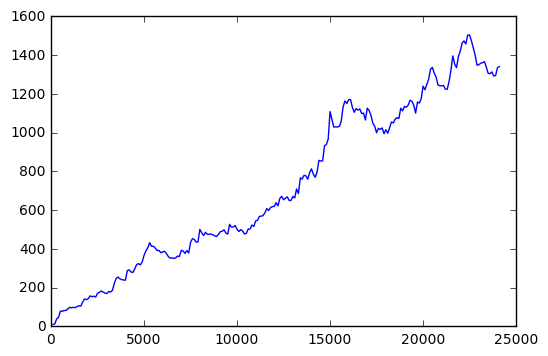

 16%|█▌        | 24110/150000 [1:56:09<10:01:29,  3.49it/s]

iter=24110	epsilon=0.145	loss=8.775	reward/tick=1.601


 16%|█▌        | 24120/150000 [1:56:11<7:17:38,  4.79it/s]

iter=24120	epsilon=0.145	loss=10.569	reward/tick=1.596


 16%|█▌        | 24130/150000 [1:56:13<7:14:37,  4.83it/s]

iter=24130	epsilon=0.145	loss=17.946	reward/tick=1.841


 16%|█▌        | 24140/150000 [1:56:15<7:19:56,  4.77it/s]

iter=24140	epsilon=0.145	loss=11.187	reward/tick=1.759


 16%|█▌        | 24150/150000 [1:56:17<8:16:35,  4.22it/s]

iter=24150	epsilon=0.145	loss=6.942	reward/tick=1.721


 16%|█▌        | 24160/150000 [1:56:19<7:14:59,  4.82it/s]

iter=24160	epsilon=0.144	loss=5.296	reward/tick=1.905


 16%|█▌        | 24170/150000 [1:56:21<7:11:43,  4.86it/s]

iter=24170	epsilon=0.144	loss=3.790	reward/tick=1.860


 16%|█▌        | 24180/150000 [1:56:23<7:23:14,  4.73it/s]

In [ ]:
from tqdm import trange
from IPython.display import clear_output


for i in trange(150000):    
    
    ##update agent's epsilon (in e-greedy policy)
    current_epsilon = 0.01 + 0.45*np.exp(-epoch_counter/20000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))

    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()
    targetnet.load_weights(0.01)
    
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
                                                               current_epsilon,
                                                               loss,
                                                               reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        action_layer.epsilon.set_value(0)
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        action_layer.epsilon.set_value(np.float32(current_epsilon))
        
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key=lambda (t,r):t)))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
import pandas as pd
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))

In [ ]:
from agentnet.utils.persistence import save
save(action_layer,"pacman.pcl")

In [ ]:
###LOAD FROM HERE
from agentnet.utils.persistence import load
load(action_layer,"pacman.pcl")

In [ ]:
action_layer.epsilon.set_value(0.01)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%np.mean(rw))

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__